# COMP 579: Assignment 3
March 19th, 2024
Group 86:
- Mathieu Geoffroy 260986559
- Ryan Reszetnik 260948454

## 1. Value-based methods with linear function approximation

### 1.1. Setup Environment

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
import multiprocess

In [2]:
#create a tile encoding of the state space to ma
def create_tiling_for_feature(low,high,num_tiles_per_tiling,num_tilings,x):
    # print(low,high,num_tiles_per_tiling,num_tilings,x)#-1.2 0.6 2 8 [-0.5906537  0.       ]
    num_deltas = (num_tiles_per_tiling-1)*num_tilings+1
    tiling = np.linspace(low,high,num_deltas)
    #find the index that x falls into
    idx = np.digitize(x,tiling)
    #idx is 1 indexed
    idx = idx - 1

    representation = np.zeros((num_tilings,num_tiles_per_tiling))
    for i in range(num_tilings):
        one_hot = (idx+num_tilings-i-1) // num_tiles_per_tiling
        #convert to one hot encoding
        # print(one_hot,num_tilings,i,idx,num_tiles_per_tiling)#4 8 0 2 2
        representation[i][one_hot] = 1
    return representation
def create_tiling(env,num_tiles_per_tiling,num_tilings,state):
    low = env.observation_space.low
    high = env.observation_space.high
    num_features = len(low)
    tiling = np.zeros((num_features,num_tilings,num_tiles_per_tiling))
    for i in range(num_features):
        tiling[i] = create_tiling_for_feature(low[i],high[i],num_tiles_per_tiling,num_tilings,state[i])
    return tiling
def create_flat_tiling(env,num_tiles_per_tiling,num_tilings,state):
    tiling = create_tiling(env,num_tiles_per_tiling,num_tilings,state)
    flat_tiling = tiling.flatten()
    return flat_tiling
#test the tiling
mtn_car = gym.make('MountainCar-v0')
state = mtn_car.reset()
print(state)
print(create_tiling(mtn_car,8,2,state[0]))
tiling = create_flat_tiling(mtn_car,8,2,state[0])
print(tiling)

(array([-0.40182814,  0.        ], dtype=float32), {})
[[[1. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0.]]]
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]


In [3]:
class Q_Network():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.uniform(-0.001, 0.001, (input_dim, output_dim))
    def forward(self, x):
        return x @ self.weights
    def backward(self, x, y_hat, lr):
        self.weights = self.weights + lr * x.T @ (y_hat - x @ self.weights)

#test the Q network to make sure it trains
q_network = Q_Network(16,3)
eg_input = np.random.uniform(-1,1,(1,16))
eg_output = np.random.uniform(-1,1,(1,3))

for i in range(1000):
    y_hat = q_network.forward(eg_input)
    q_network.backward(eg_input, eg_output, 0.01)
    if i % 100 == 0:
        print(np.mean(np.square(y_hat-eg_output)))
    


0.5148293565570289
1.2761843737640148e-05
3.1634687010314075e-10
7.84176207856411e-15
1.9438542221031691e-19
4.81877265373851e-24
1.209011510262161e-28
6.327321843960199e-31
6.327321843960199e-31
6.327321843960199e-31


### 1.2 Q-learning with linear function approximation

In [4]:
def epsilon_greedy(q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_values))
    else:
        return np.argmax(q_values)

class QLearning:
    def __init__(self, env, alpha, gamma,epsilon,num_tilings,num_tiles_per_tiling):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_tilings = num_tilings
        self.num_tiles_per_tiling = num_tiles_per_tiling
        self.Q = Q_Network(num_tilings*num_tiles_per_tiling*len(env.observation_space.low), env.action_space.n)
    def reset(self):
        self.Q = Q_Network(self.num_tilings*self.num_tiles_per_tiling*len(self.env.observation_space.low), self.env.action_space.n)
    def select_action(self, s):
        tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s)
        q_values = self.Q.forward(tile_coding_state)
        action = epsilon_greedy(q_values, self.epsilon)
        return action

    def update(self, s, a, r, s_prime):
        tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s)
        q_values = self.Q.forward(tile_coding_state)
        next_tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s_prime)
        next_q_values = self.Q.forward(next_tile_coding_state)
        next_action = np.argmax(next_q_values)
        target = r + self.gamma * next_q_values[next_action]
        q_values[a] = q_values[a] + self.alpha * (target - q_values[a])
        self.Q.backward(tile_coding_state.reshape(1, -1), q_values.reshape(1, -1), self.alpha)
        return

class ExpectedSarsa:
    def __init__(self, env, alpha, gamma,epsilon,num_tilings,num_tiles_per_tiling):
        # write your solution here
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_tilings = num_tilings
        self.num_tiles_per_tiling = num_tiles_per_tiling
        self.Q = Q_Network(num_tilings*num_tiles_per_tiling*len(env.observation_space.low), env.action_space.n)
    def reset(self):
        self.Q = Q_Network(self.num_tilings*self.num_tiles_per_tiling*len(self.env.observation_space.low), self.env.action_space.n)
    def select_action(self, s):
        tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s)
        q_values = self.Q.forward(tile_coding_state)
        action = epsilon_greedy(q_values, self.epsilon)
        return action
    def update(self, s, a, r, s_prime):
        tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s)
        q_values = self.Q.forward(tile_coding_state)
        next_tile_coding_state = create_flat_tiling(self.env,self.num_tiles_per_tiling,self.num_tilings,s_prime)
        next_q_values = self.Q.forward(next_tile_coding_state)
        expected_value = np.sum(next_q_values * (1 - self.epsilon) + self.epsilon / self.env.action_space.n)
        target = r + self.gamma * expected_value
        q_values[a] = q_values[a] + self.alpha * (target - q_values[a])
        self.Q.backward(tile_coding_state.reshape(1, -1), q_values.reshape(1, -1), self.alpha)
        return

In [5]:
def run_episoid(agent,env):
    state = env.reset()[0]
    cum_reward = 0
    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        cum_reward += reward
        state = next_state
        if terminated or truncated:
            break
    return cum_reward
def run_experiments(agent,env,num_episodes,num_experiments,experiment_id):
    rewards = []
    for k in range(num_experiments):
        agent.reset()
        episoid_rewards = []
        for i in range(num_episodes):
            reward = run_episoid(agent,env)
            episoid_rewards.append(reward)
        rewards.append(episoid_rewards)
        print("Finished experiment", k, "on experiment", experiment_id)
    return np.array(rewards)

In [6]:
alphas = [1/4,1/8,1/16]
epsilons = [1/4,1/8,1/16]
GAMMA = 0.99
NUM_TILINGS = 4
NUM_TILES_PER_TILING = 7
NUM_EPISOIDS = 1000
NUM_EXPERIMENTS = 50

NUM_PROCESSES = 4
SAVE_FOLDER = "results"

def get_experiment_id(alpha,epsilon,isMountainCar,isQLearning,temp=0):
    experiment_name = "cart_pole"
    if isMountainCar:
        experiment_name = "mountain_car"
    algorithm = "expected_sarsa"
    if isQLearning:
        algorithm = "q_learning"
    return "{}-{}-{}-{}-{}-{}-{}-{}-{}-{}".format(alpha,epsilon,GAMMA,NUM_TILINGS,NUM_TILES_PER_TILING,NUM_EPISOIDS,NUM_EXPERIMENTS,experiment_name,algorithm,temp)


In [7]:
def run_experiment(alpha,epsilon,isMountainCar,isQLearning):
    experiment_id = get_experiment_id(alpha,epsilon,isMountainCar,isQLearning)
    try:
        os.mkdir(SAVE_FOLDER)
    except:
        pass
    try:
        rewards = np.load("{}/{}.npy".format(SAVE_FOLDER,experiment_id))
        print("Loaded experiment",get_experiment_id(alpha,epsilon,isMountainCar,isQLearning))
        return rewards
    except:
        pass
    if isMountainCar:
        env = gym.make('MountainCar-v0')
    else:
        env = gym.make('CartPole-v1')
    if isQLearning:
        agent = QLearning(env, alpha, GAMMA,epsilon,NUM_TILINGS,NUM_TILES_PER_TILING)
    else:
        agent = ExpectedSarsa(env, alpha, GAMMA,epsilon,NUM_TILINGS,NUM_TILES_PER_TILING)
    rewards = run_experiments(agent,env,NUM_EPISOIDS,NUM_EXPERIMENTS,experiment_id)
    
    print("Finished experiment",experiment_id)
    np.save("{}/{}.npy".format(SAVE_FOLDER,experiment_id),rewards)
    return rewards

Loaded experimentLoaded experimentLoaded experimentLoaded experiment    0.25-0.125-0.99-4-7-1000-50-mountain_car-q_learning-00.25-0.25-0.99-4-7-1000-50-mountain_car-q_learning-00.125-0.25-0.99-4-7-1000-50-mountain_car-q_learning-00.25-0.0625-0.99-4-7-1000-50-mountain_car-q_learning-0



Loaded experimentLoaded experimentLoaded experiment Loaded experiment  0.125-0.125-0.99-4-7-1000-50-mountain_car-q_learning-00.125-0.0625-0.99-4-7-1000-50-mountain_car-q_learning-0 

0.0625-0.25-0.99-4-7-1000-50-mountain_car-q_learning-00.0625-0.125-0.99-4-7-1000-50-mountain_car-q_learning-0

Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-mountain_car-q_learning-0


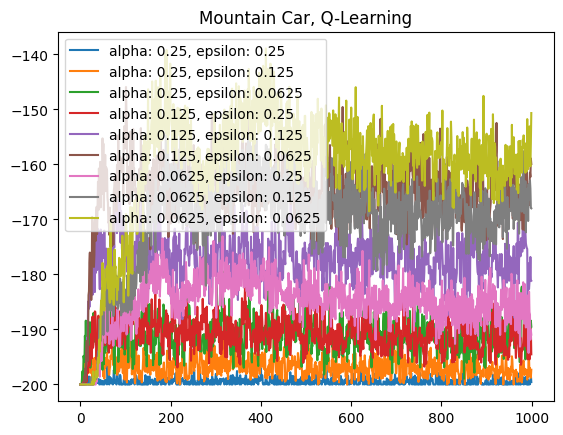

In [8]:
#mountain car, q learning
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha':alpha,
            'epsilon':epsilon,
            'isMountainCar':True,
            'isQLearning':True
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha,epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [(experiment['alpha'],experiment['epsilon'],experiment['isMountainCar'],experiment['isQLearning']) for experiment in experiments])

for result,label in zip(results,labels):
    plt.plot(np.mean(result,axis=0),label=label)
        
plt.title("Mountain Car, Q-Learning")
plt.legend()
plt.show()

Loaded experimentLoaded experimentLoaded experimentLoaded experiment    0.25-0.0625-0.99-4-7-1000-50-mountain_car-expected_sarsa-00.25-0.25-0.99-4-7-1000-50-mountain_car-expected_sarsa-00.25-0.125-0.99-4-7-1000-50-mountain_car-expected_sarsa-00.125-0.25-0.99-4-7-1000-50-mountain_car-expected_sarsa-0



Loaded experimentLoaded experimentLoaded experimentLoaded experiment    0.0625-0.25-0.99-4-7-1000-50-mountain_car-expected_sarsa-00.0625-0.125-0.99-4-7-1000-50-mountain_car-expected_sarsa-00.125-0.0625-0.99-4-7-1000-50-mountain_car-expected_sarsa-00.125-0.125-0.99-4-7-1000-50-mountain_car-expected_sarsa-0



Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-mountain_car-expected_sarsa-0


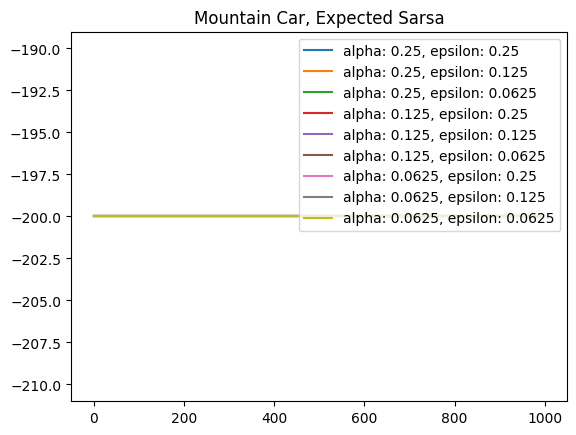

In [9]:
#mountain car, expected sarsa
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha':alpha,
            'epsilon':epsilon,
            'isMountainCar':True,
            'isQLearning':False
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha,epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [(experiment['alpha'],experiment['epsilon'],experiment['isMountainCar'],experiment['isQLearning']) for experiment in experiments])

for result,label in zip(results,labels):
    plt.plot(np.mean(result,axis=0),label=label)

plt.title("Mountain Car, Expected Sarsa")
plt.legend()
plt.show()

Loaded experimentLoaded experimentLoaded experimentLoaded experiment    0.25-0.0625-0.99-4-7-1000-50-cart_pole-q_learning-00.25-0.125-0.99-4-7-1000-50-cart_pole-q_learning-00.125-0.25-0.99-4-7-1000-50-cart_pole-q_learning-00.25-0.25-0.99-4-7-1000-50-cart_pole-q_learning-0



Loaded experimentLoaded experimentLoaded experimentLoaded experiment    0.125-0.0625-0.99-4-7-1000-50-cart_pole-q_learning-00.0625-0.25-0.99-4-7-1000-50-cart_pole-q_learning-00.0625-0.125-0.99-4-7-1000-50-cart_pole-q_learning-00.125-0.125-0.99-4-7-1000-50-cart_pole-q_learning-0



Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-cart_pole-q_learning-0


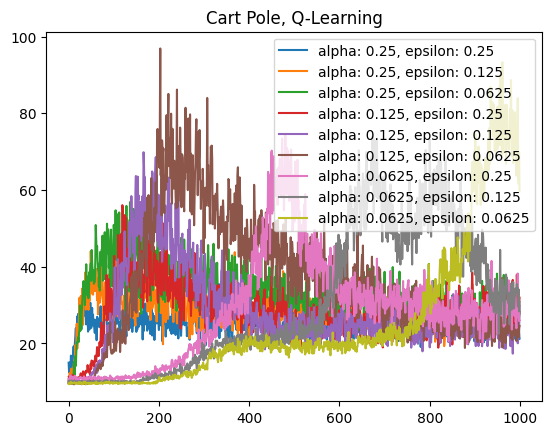

In [10]:
#cart pole, q learning
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha':alpha,
            'epsilon':epsilon,
            'isMountainCar':False,
            'isQLearning':True
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha,epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [(experiment['alpha'],experiment['epsilon'],experiment['isMountainCar'],experiment['isQLearning']) for experiment in experiments])

for result,label in zip(results,labels):
    plt.plot(np.mean(result,axis=0),label=label)
plt.title("Cart Pole, Q-Learning")
plt.legend()
plt.show()

Loaded experimentLoaded experimentLoaded experimentLoaded experiment    0.25-0.0625-0.99-4-7-1000-50-cart_pole-expected_sarsa-00.25-0.25-0.99-4-7-1000-50-cart_pole-expected_sarsa-00.125-0.25-0.99-4-7-1000-50-cart_pole-expected_sarsa-00.25-0.125-0.99-4-7-1000-50-cart_pole-expected_sarsa-0



Loaded experimentLoaded experimentLoaded experimentLoaded experiment    0.0625-0.125-0.99-4-7-1000-50-cart_pole-expected_sarsa-00.0625-0.25-0.99-4-7-1000-50-cart_pole-expected_sarsa-00.125-0.0625-0.99-4-7-1000-50-cart_pole-expected_sarsa-00.125-0.125-0.99-4-7-1000-50-cart_pole-expected_sarsa-0



Loaded experiment 0.0625-0.0625-0.99-4-7-1000-50-cart_pole-expected_sarsa-0


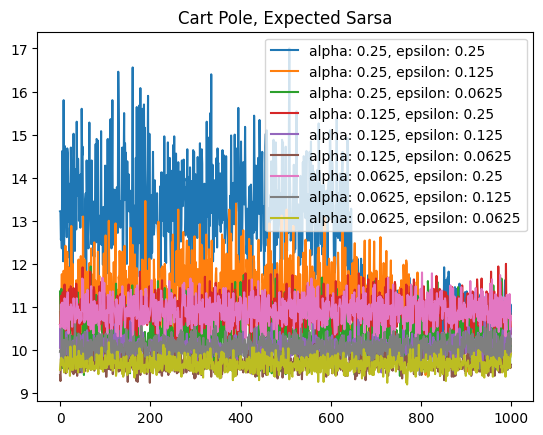

In [11]:
#cart pole, expected sarsa
results = []
labels = []
experiments = []
for alpha in alphas:
    for epsilon in epsilons:
        params = {
            'alpha':alpha,
            'epsilon':epsilon,
            'isMountainCar':False,
            'isQLearning':False
        }
        experiments.append(params)
        labels.append("alpha: {}, epsilon: {}".format(alpha,epsilon))

with multiprocess.Pool(processes=NUM_PROCESSES) as pool:
    results = pool.starmap(run_experiment, [(experiment['alpha'],experiment['epsilon'],experiment['isMountainCar'],experiment['isQLearning']) for experiment in experiments])

for result,label in zip(results,labels):
    plt.plot(np.mean(result,axis=0),label=label)
    
plt.title("Cart Pole, Expected Sarsa")
plt.legend()
plt.show()

## 2. Policy Gradient Theorem

## 3. Policy-based methods with linear function approximation